In [1]:
#the code is based on https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [62]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import os
import pickle

nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [47]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape
candidate_sentences.head(3)['sentence'][0]

'confused and frustrated, connie decides to leave on her own.'

In [2]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence
    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
        #############################################################

    return [ent1.strip(), ent2.strip()]

In [45]:
months = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 64, 70, 73, 76, 77, 84]
rootdir = '/home/gknee/gitWorkspace/childes_graph_playground/data/'
content_monthly = []
for month in months:    
    with open(rootdir + str(month)) as f:
        content = f.read().splitlines()
        content_monthly.append(content)
        
content_merged = []
for month in content_monthly:
    for sent in month:
        content_merged.append(sent)
print(content_merged)

['ah o', 'a o w', 'www', 'a o ah o a o', 'a', 'Daddy', 'jwblublublujujw wjawe', 'peepee peepee poddy', 'book', 'bye bowwow', 'cookie', 'cookie', 'cookie', 'hi baby', 'Mommy oh Deedee', 'Deedee', 'cookie', 'cookie  cookie', 'Daddy byebye Daddy', 'hi kee hi kiddy  kiddy', 'papu', 'baby', 'hi Deedee', 'hi Mama', 'hi Dada', 'hi Daddy', 'oh my ba', 'carcar  Dada', 'olvb baby olvb baby', 'byebye Daddy', 'cookie', 'cookie', 'papu', 'car', 'byebye car', 'bye bye da Dada bye', 'bye bye bye bye', 'car', 'bowwow', 'tee', 'car car hi car', 'uhuh Lola', 'Mommy me bye', 'Mommy bye car', 'byebye', 'car', 'eye', 'baby', 'baby horsie', 'hi baby', 'poddy', 'peepee', 'poo', 'Mama tee', 'Mama cookie', 'hi Deedee', 'hi kiddy  kiddy  kiddy', 'hi bowwow', 'papu', 'hi carcar', 'thank Deedee', 'hi bowwow', 'uhoh bab uhoh uhoh', 'hi baby baby baby', 'pay  pay', 'baby baby baby baby', 'baby baby baby', 'baby baba', 'out', 'out', 'out out out', 'hi horsie', 'hi horsie', 'hi horsie', 'hi Dada bye Da', 'hi Nana', '

In [72]:
for idx, month_content in enumerate(content_monthly):
    entity_pairs = []
    print(months[idx])
    for sentence in month_content:
        entity_pairs.append(get_entities(sentence))
    pickle.dump( entity_pairs, open( "pickles/entity_pairs_all" + str(months[idx]) + ".p", "wb" ) )

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
47
48
49
50
51
52
53
54
55
58
64
70
73
76
77
84


In [66]:
# pickle.dump( entity_pairs, open( "pickles/entity_pairs_all.p", "wb" ) )

In [54]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [76]:
for idx, month_content in enumerate(content_monthly):
    entity_pairs = []
    print(months[idx])
    relations = [get_relation(sentence) for sentence in month_content]
    pickle.dump( relations, open( "pickles/relations" + str(months[idx]) + ".p", "wb" ))

13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
47
48
49
50
51
52
53
54
55
58
64
70
73
76
77
84


In [65]:
# pickle.dump( relations, open( "pickles/relations_all.p", "wb" ) )

In [85]:
for month in months:
    relations = pickle.load( open( "pickles/relations" + str(month) + ".p", "rb" ) )
    print("***")
    print("month = " + str(month))
    print(pd.Series(relations).value_counts()[:5])

***
month = 13
o        2
www      1
a        1
wjawe    1
w        1
dtype: int64
***
month = 14
Series([], dtype: int64)
***
month = 15
hi        108
Mommy      42
baby       31
Dada       26
cookie     21
dtype: int64
***
month = 16
cy        30
see       18
hi        16
bubble    16
go        14
dtype: int64
***
month = 17
no       50
baby     34
car      20
toe      19
Daddy    17
dtype: int64
***
month = 18
Laura    54
no       46
here     29
yeah     26
Daddy    26
dtype: int64
***
month = 19
yeah     52
Dwww     39
no       33
want     23
Daddy    23
dtype: int64
***
month = 20
want      12
yeah       9
eat        9
Daddy      5
caught     5
dtype: int64
***
month = 21
is       19
baby     18
get      18
penny    17
do       13
dtype: int64
***
month = 22
no       33
yeah     29
ah       19
is       18
Daddy    17
dtype: int64
***
month = 23
want    59
have    39
is      35
no      25
do      24
dtype: int64
***
month = 24
mhm      16
Mummy    15
write    15
want     15
huh    

/home/gknee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [58]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

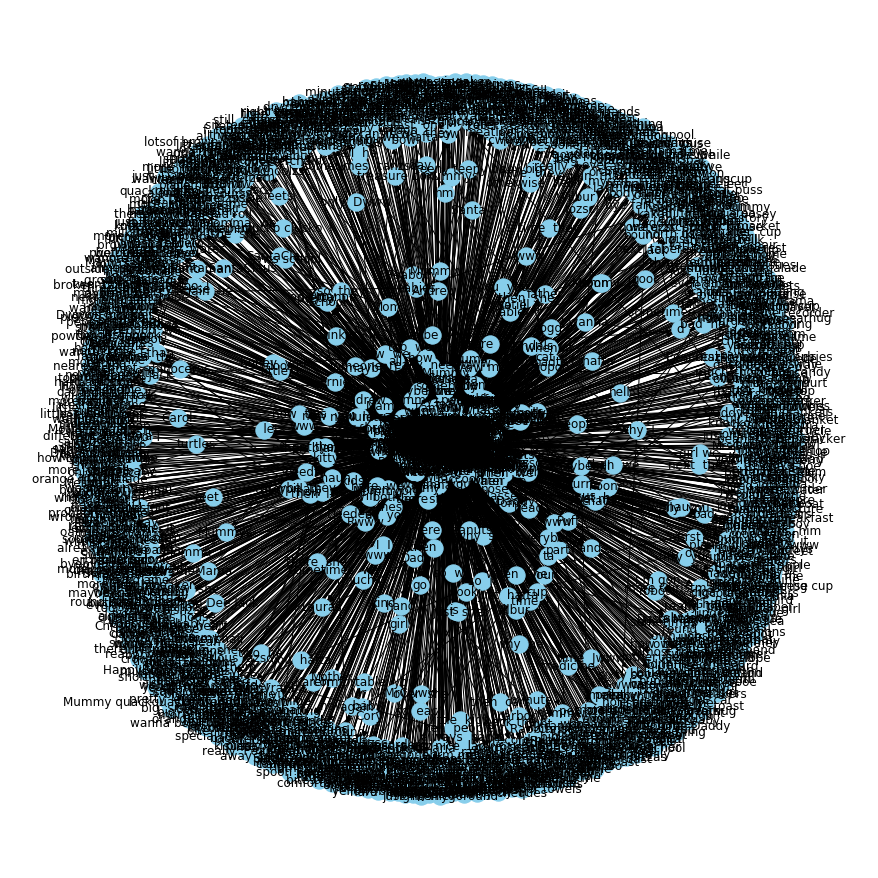

In [59]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

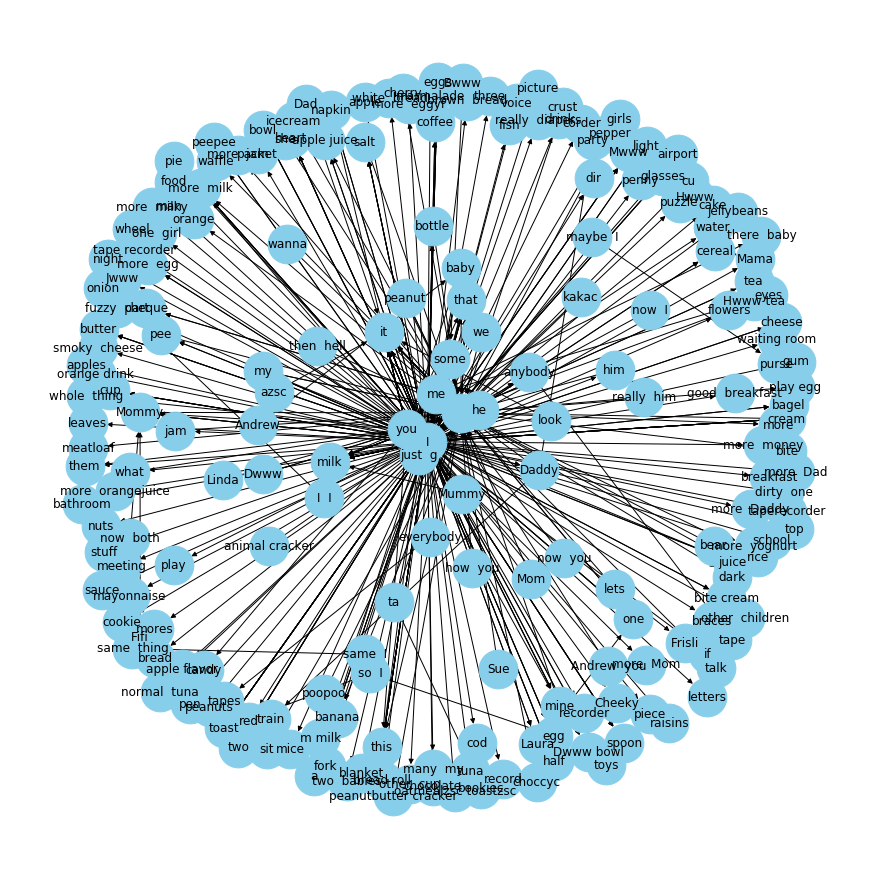

In [60]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="want"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()